# Asymptomatic transmission

Since we {doc}`first introduced the SIR model <continuous>` you may have had the niggling suspicion that &ndash; while it's obviously a *simple* model of a disease &ndash; maybe it's *too* simple. We know from {doc}`looking at diseases' progression <progress>` (and from experience) that diseases are much more complicated than SIR suggests. In particular, many of them (the Type A diseases) have incubation periods longer than their latent periods, meaning that an individual can infect others while not showing any outward symptoms. This **{index}`asymptomatic transmission`** is a problem for disease control, since it means that infectious people aren't immediately identifiable, either by people noticing their symptoms or by them noticing their own symptoms themselves.

There is of course nothing sacrosanct about SIR. It's a model: a generally useful one for studying disease phenomena, but one that we can (and should) either ditch or enrich whenever we see deficiencies or want to explore some new phenomena. One possible extension to SIR is to allow asymptomatic transmission, leading to a model that includes individuals who have been "exposed" to the disease, and who are infectious but not yet visibly symptomatic.

(sec:seir-seir)=
## SEIR

{index}`SEIR` is another {ref}`compartmented model of disease <sec:continuous-compartmented-model>`. Like SIR, it includes {index}`compartments <compartmented model>` for individuals who are susceptible to infection, infected (and infectious), and removed from the disease by recovery or death. However, it adds a fourth compartment:

- **{index}`Exposed <compartment;exposed>` (E)**, representing those people who have caught the disease and can pass it on but who are not yet showing symptoms

Exposed individuals, like infected individuals, can transmit the disease to neighbouring (if we are using a networked model) susceptibles. They also transition from exposed to infected at some rate, capturing how their symptoms develop.

In the same way as we developed a {ref}`mathematical model of SIR <sec:continuous-sir-model>` in terms of how the populations of the different compartments changed over time, we can do the {index}`same thing <models;mathematical>` for SEIR. We expect to see another equation showing how the population of **E** changes, and indeed we do:

$$
\begin{align*}
    \Delta S &= -p_{\mathit{infect}} \, SI - p_{\mathit{infectA}} \, SE \\
    \Delta E &= p_{\mathit{infect}} \, SI + p_{\mathit{infectA}} \, SE - p_{symptoms} \, E \\
    \Delta I &= p_{symptoms} \, E - p_{remove} I \\
    \Delta R &= p_{remove} I
\end{align*}
$$

What this says is that $\Delta S$, the change in population of $S$, reduces $S$ in two ways: infections coming from infected individuals at a rate that depends on the number of susceptible-infected interactions in the population &ndash; exactly as happens in SIR &ndash; but also additionally from exposed (asymptomatic) individuals at a rate (which may be different) that depends on the number of susceptible-exposed interactions. The number of exposed individuals grows at this rate, and decreases as exposed individuals develop symptoms and become infected.

Notice that we now have four compartments and four {index}`parameters <parameter>`:

- $p_{\mathit{infect}}$, the probability that a susceptible-infected interaction results in infection;
- $p_{\mathit{infectA}}$, the probability that a susceptible-exposed interaction results in infection;
- $p_{symptoms}$, the probability that an exposed individual will show symptoms; and
- $p_{remove}$, the probability that an infected individual will be removed.

(sec:seir-degrees-of-freedom)=
## The pros and cons of a richer model

It's reasonable to ask at this point why we don't *always* use SEIR instead of SIR, since it's clearly closer to the way a lot of real-world diseases behave. Isn't SIR *too* simple, when an only slightly more complex model is readily available in SEIR?

There are two basic arguments to make here. Firstly, SEIR has twice as many parameters as SIR: four instead of two, each of which controls some aspect of how the process works. An alternative, and very suggestive, name for the number of parameters is the number of **{index}`degrees of freedom`** a model has. A model with more degrees of freedom has more "knobs you can turn" to change its behaviour. And this is both good and bad. It's good because it lets us fine-tune the model, possibly produce additional effects that a simpler model (with fewer degrees of freedom) wouldn't show. But it's bad because that means there's more work to do to fully explore all the things a model might do. If we're modelling a "real" disease, we have to collect twice as manay parameters about it. Some of these might be hard to collect: how would you go about funding $p_{\mathit{infectA}}$, the rate of asymptopmatic infection, when by definition asymptomatic people are hard to find?

The second argument cuts to the heart of scientific model-making. As we've seen, SIR lets us demonstrate a lot of interesting phenomena. It varies depending on the infection rate, depending on the network topology, depending on the way we apply individual countermeasures, and so forth &ndash; and we haven't finished yet! We can say a lot about diseases *in general* from SIR, even though there are lots of diseases that it can't robustly capture and for which *in detail*  SEIR is better. So whether a given model is "correct" depends to a large extent on the questions we're asking.

```{margin}

This is related to the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor), which may be paraphrased as "keep things as simple as possible (but no simpler)".
```

**Scientists generally prefer the simplest model that's complex enough to answer the questions they're asking**. That often means minimising the number of degrees of freedom in a model, to simplify exploration and to avoid any risk that it might be "steered" in a particular direction by unfounded assumptions. It also means that a lot of detail is elided, with the danger that some of this detail may turn out to be important. This is what makes science itself into a process of continuous error and correction. 

## Simulating SEIR

We can of course build simulations of SEIR running over a network &ndash; so let's do so.

We now have four parameters to specify instead of SIR's two: the rate $p_{\mathit{infectA}}$ of asymptomatic transmission (from exposed individuals to susceptibles), and the rate $p_{symptoms}$ at which symptoms show themselves. We'll explore the way in which asymptomatic transmission affects the size of the eventual outbreak. SEIR also includes an additional event when a person is **{index}`exposed <events;exposed>`** to the disease (and becomes infectious). We re-use the **{index}`infected <events;infected>`** event as when the person becomes symptomatic. 

In [1]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.75)

In [ ]:
lab = epyc.ClusterLab(profile='hogun',
                      notebook=epyc.JSONLabNotebook('datasets/seir-er.json', create=True))

In [263]:
with lab.sync_imports():
    import time
    import networkx
    import epyc
    import epydemic
    import numpy
    import mpmath
print('{n} engines available'.format(n = lab.numberOfEngines()))

importing time on engine(s)
importing networkx on engine(s)
importing epyc on engine(s)
importing epydemic on engine(s)
importing numpy on engine(s)
importing mpmath on engine(s)
78 engines available


In [2]:
# from https://nbviewer.jupyter.org/gist/minrk/4470122
def pxlocal(line, cell):
    ip = get_ipython()
    ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")    

In [3]:
%%pxlocal

class ERNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental parameters
    N = 'N'
    KMEAN = 'kmean'
    
    def __init__(self, p):
        super(ERNetworkDynamics, self).__init__(p)
        
    def configure(self, params):
        super(ERNetworkDynamics, self).configure(params)
        
        # build a random ER network with the given parameters
        N = params[self.N]
        kmean = params[self.KMEAN]
        pEdge = (kmean + 0.09) / N
        g = networkx.gnp_random_graph(N, pEdge)
        self.setNetworkPrototype(g)

In [4]:
%%pxlocal

class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

Monitoring an SEIR epidemic is essentially the same as the way we monitored SIR: we record the sizes of the compartments as the epidemic progresses.

In [5]:
%%pxlocal

class MonitoredSEIR(epydemic.SEIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSEIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSEIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SEIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SEIR.REMOVED)

Let's explore the outbreak on an ER network again, choosing some values for the different disease parameters and then exploring how the results vary with the value of $p_{\mathit{infectA}}$.

In [6]:
# network parameters
N = 10000
kmean = 40

# SEIR disease parameters
pExposed = 0.001
pSymptoms = 0.002
pRemove = 0.002
pInfect = 0.000075

In [ ]:
lab[ERNetworkDynamics.N] = N
lab[ERNetworkDynamics.KMEAN] = kmean
lab[epydemic.SEIR.P_EXPOSED] = pExposed
lab[epydemic.SEIR.P_SYMPTOMS] = pSymptoms
lab[epydemic.SEIR.P_REMOVE] = pRemove
lab[epydemic.SEIR.P_INFECT_SYMPTOMATIC] = pInfect
lab[epydemic.SEIR.P_INFECT_ASYMPTOMATIC] = numpy.linspace(0.00001, 0.0002, num=50)

In [18]:
m = epydemic.SEIR()
e = ERNetworkDynamics(m)
rc = lab.runExperiment(epyc.RepeatedExperiment(
                         epyc.RepeatedExperiment(e, 10),
                       10))

In [27]:
lab.readyFraction()

1.0

After much computation, we can plot the results. We'll also show the value of "normal" infection (by symptomatic individuals) for comparison.

In [7]:
df = epyc.JSONLabNotebook('datasets/seir-er.json').dataframe()

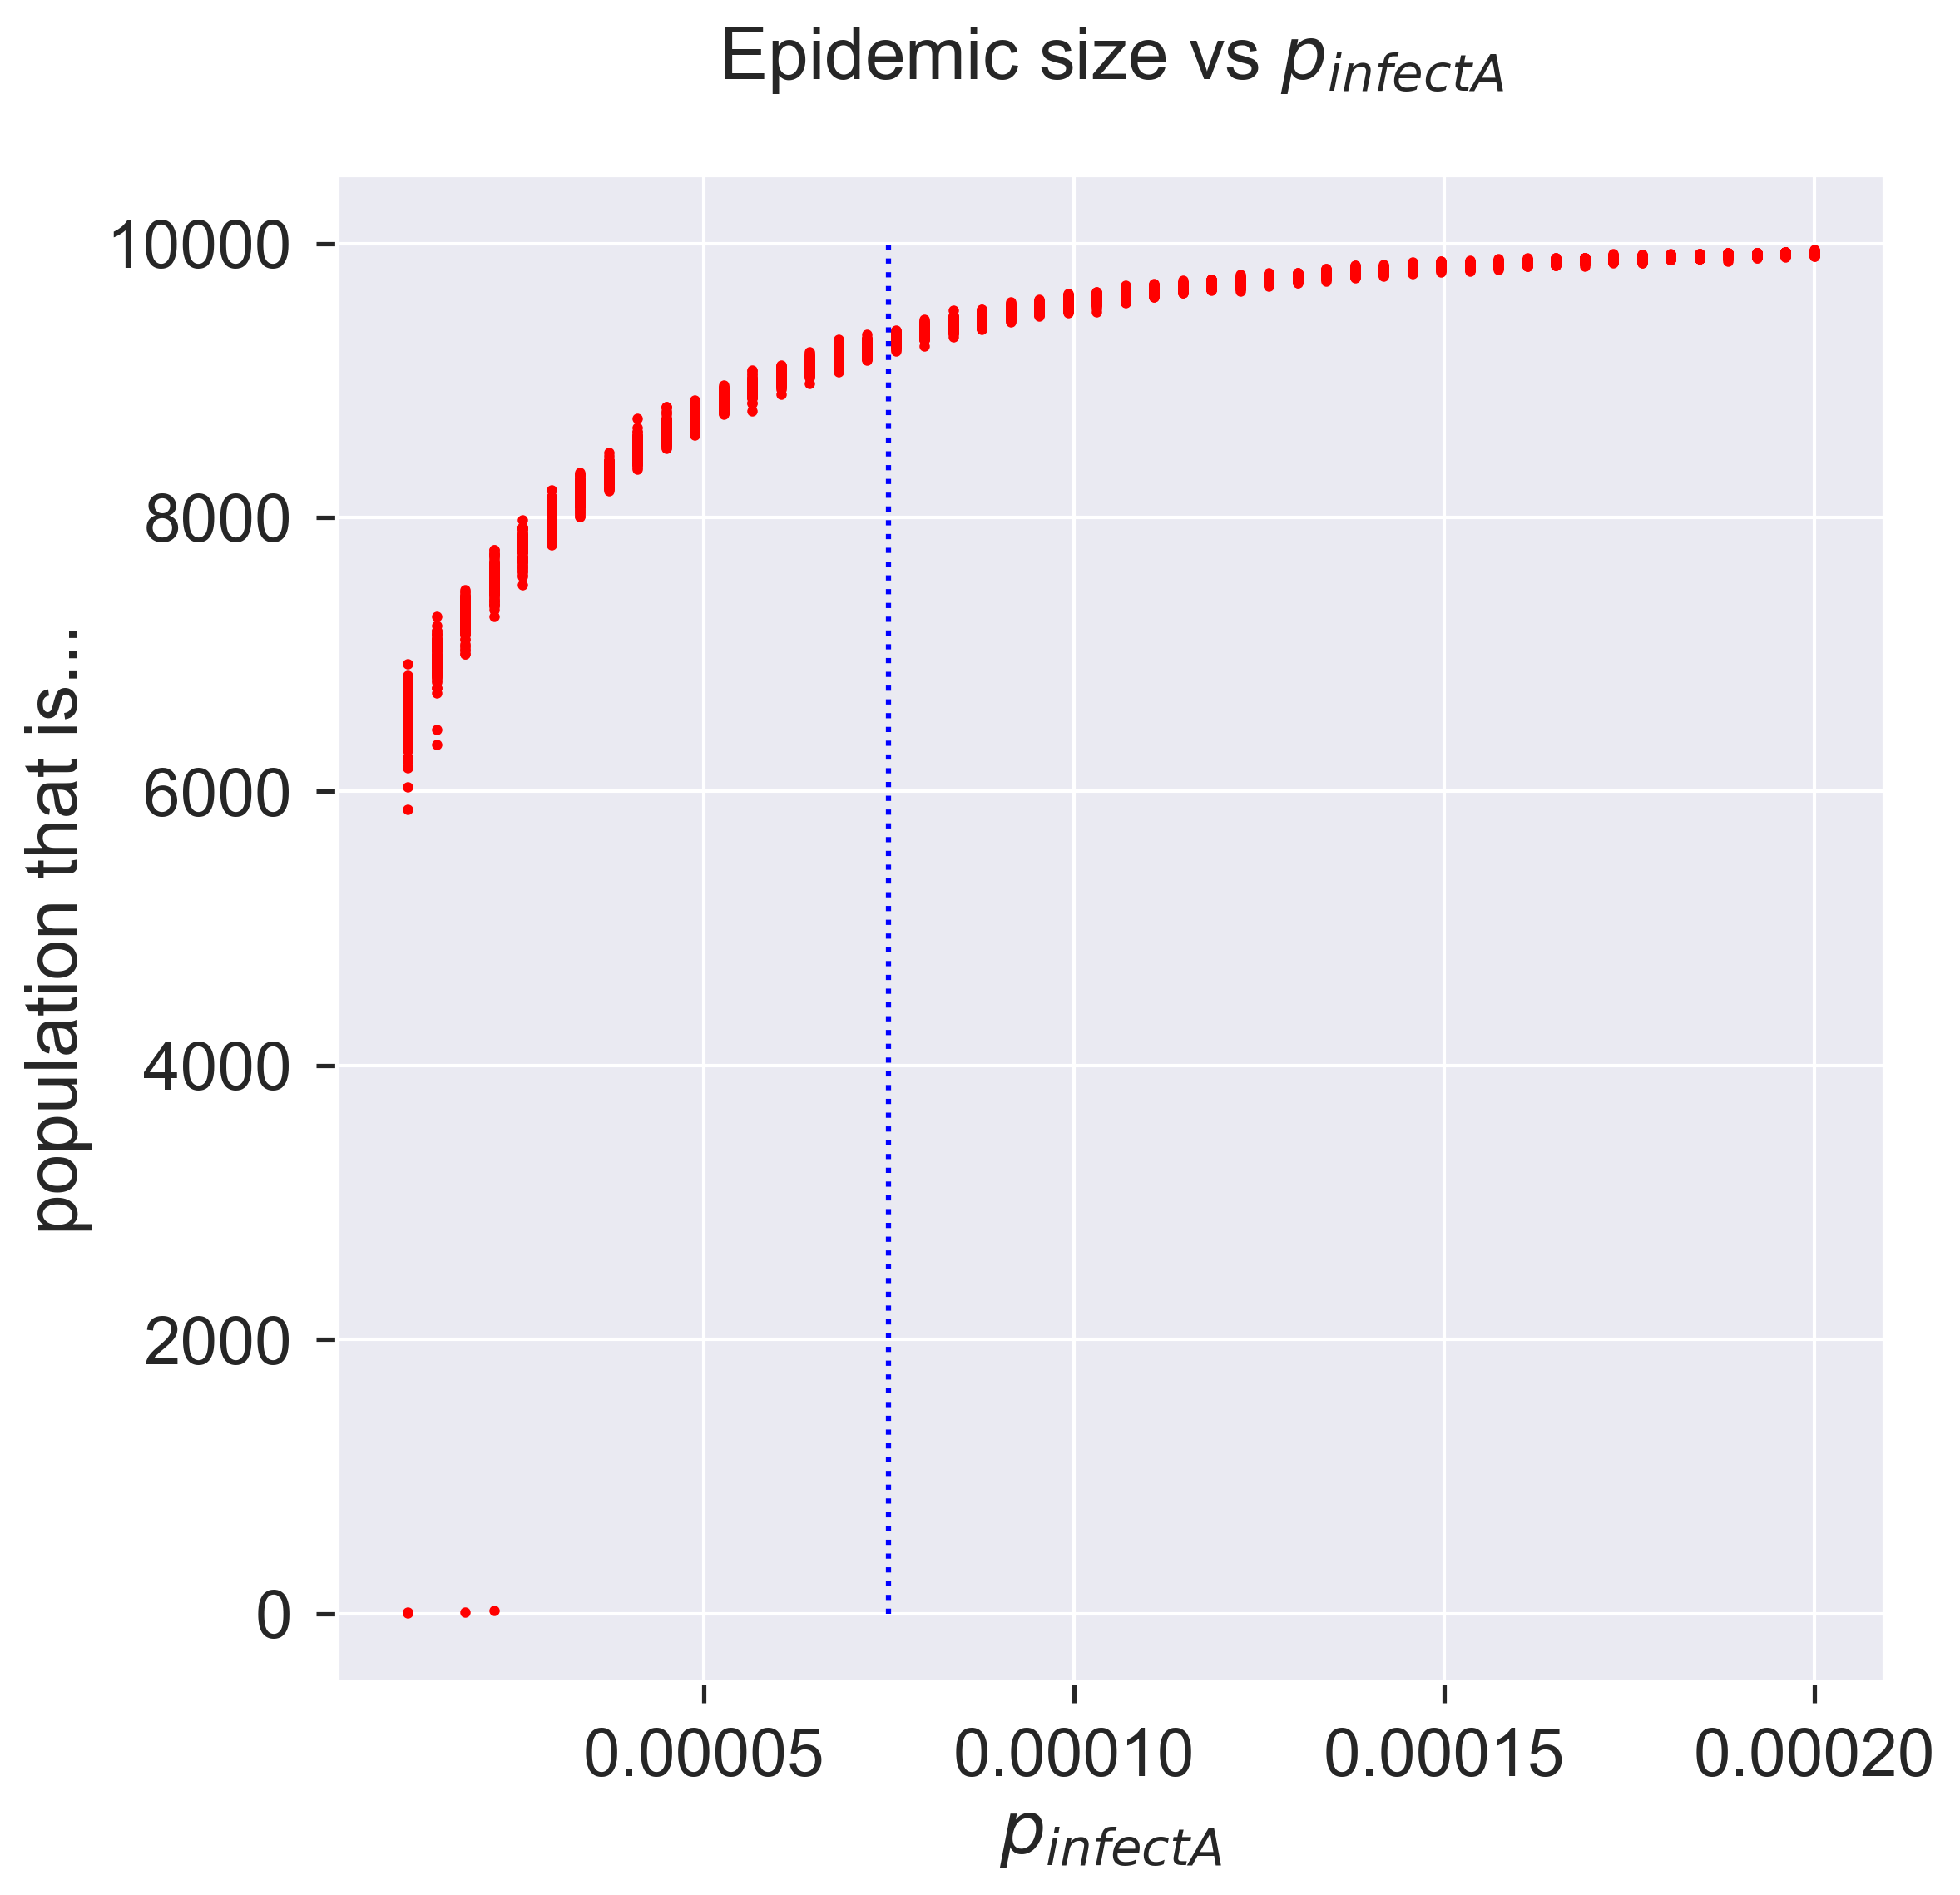

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population and
# the value of symptomatic infection
ax.plot(df[epydemic.SEIR.P_INFECT_ASYMPTOMATIC],
        df[epydemic.SEIR.REMOVED], 'r.')
ax.plot([pInfect, pInfect], [0, N], 'b:')
ax.set_xlabel('$p_{\\mathit{infectA}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infectA}}$', y=1.05)

_ = plt.show()

Compare this with the diagram we drew for the {ref}`epidemic threshold <sec:thresholds-er>`, and you'll see that the epidemic takes off a lot earlier &ndash; which is probably what we expected, since there's more infection going on. In fact even a very small amout of early infection is enough to cause an outbreak.

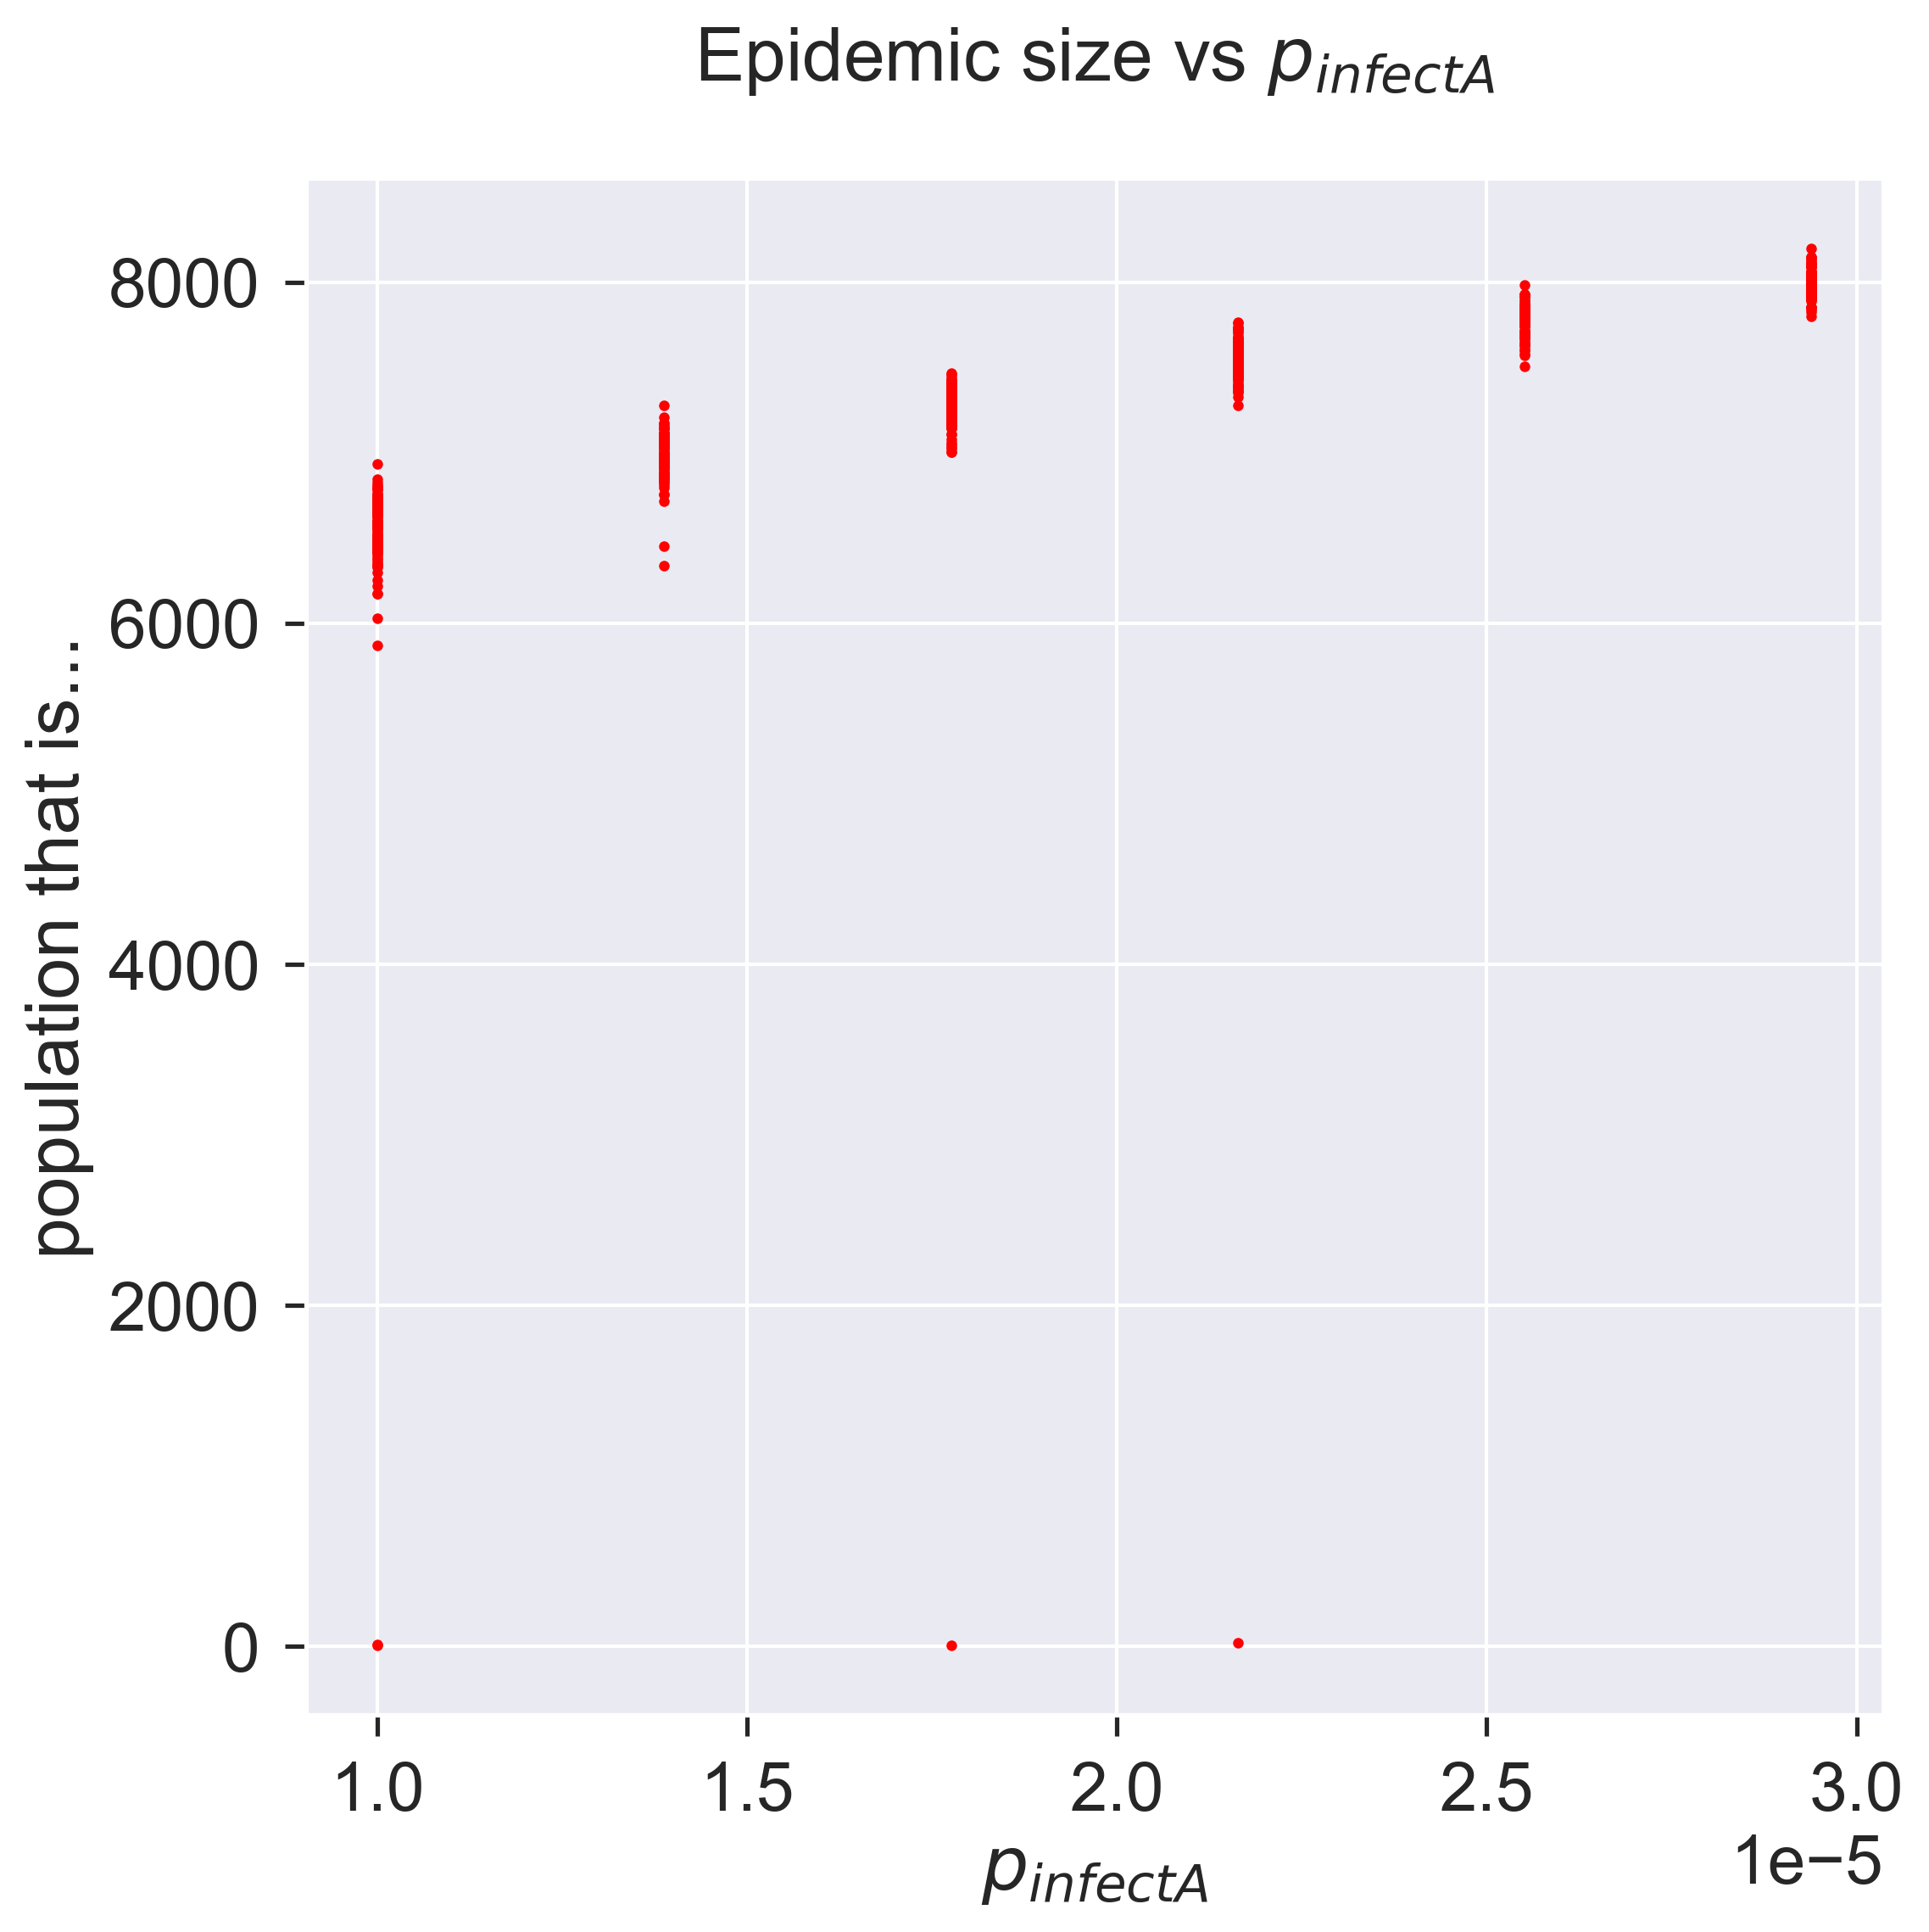

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
pInfectAs = df[[pInfect > 0.0 and pInfect < 0.00003
                for pInfect in df[epydemic.SEIR.P_INFECT_ASYMPTOMATIC]]]
ax.plot(pInfectAs[epydemic.SEIR.P_INFECT_ASYMPTOMATIC],
        pInfectAs[epydemic.SEIR.REMOVED], 'r.')
ax.set_xlabel('$p_{\\mathit{infectA}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infectA}}$', y=1.05)

_ = plt.show()

How {index}`sensitive <sensitivity>` *is* the model to asymptomatic infection? To what extent can asymptomatic infection make a less infectious disease behave like a more infectious disease that *doesn't* have asymptomatic transmission? And perhaps most importantly, can we do anything about it? It's this last question that we'll turn to now. 

(sec:seir-quarantine)=
## Adaptive countermeasures and quarantine

We {doc}`earlier <vaccination>` discussed an approach to epidemic control that involved targeting individual susceptibility, eliminating the possibility of particular individuals becoming infected. This was enough to fragment the contact network and so affect the behaviour of the epidemic.

We'll now look at a completely different strategy for {index}`countermeasures`. Instead of affecting individuals while leaving the network intact, we'll instead leave the individuals as they are but change the network as the epidemic spreads. That is to say, we'll change the structure of contacts &ndash; who's connected to whom &ndash; in response to the spread of the disease through the population. This leads to a family of **{index}`adaptive <adaptive network>`** countermeasures, since we take action to change the network in response to (adapting to) the process (disease) flowing through it.

```{margin}
The term "quarantine" comes from the Italian phrase for "forty days" (*quaranta giorni*). When Venice suffered an outbreak of the Black Death in the 14th century, the Venetians established a system whereby ships arriving in port had to moor off remote islands in the lagoon for forty days until they were judged to be disease-free &ndash; possibly the first modern example of effective disease control {cite}`Stu20`.
```
The simplest and best-known adaptive control measure is **{index}`quarantine`**, whereby we isolate individuals who are (or may be) infected to prevent them infecting others. A **proactive quarantine** isolates all incoming individuals for as long as it takes to pass through the expected {ref}`infectious period <sec:progress-periods>` of whatever disease they might be carrying. A **reactive or adaptive quarantine** waits until a person shows symptoms and then isolates them, which avoids detaining the uninfected but at the risk of allowing infected (and possibly infectious) people to circulate.

However it's done, the goal of quarantine is to reduce the effective $\mathcal{R}$ {index}`value <R value>` of the disease such that any epidemic is contained, ideally failing to take hold or at least being smaller and less intense than would otherwise be the case.

(sec:seir-adaptive-infected)=
## Reducing infection through partial quarantine

Let's introduce quarantine into our models. In the spirit of simplicity, we'll look first at SIR. 

How does quarantine manifest itself in {index}`SIR`? Infection in SIR happens when the disease passes from an infected individual to a susceptible one. Quarantine is an adaptive strategy &ndash; it happens in parallel with infection &ndash; so we'll be introducing a way of changing the network. When the disease passes to a formerly-susceptible person, we'll changes that person's connections in some way.

If this strategy was performed perfectly and immediately it would immediately stamp-out an SIR infection. Every time someone became infected, that person would be immediately and completely isolated, and so would be unable to infect anyone else. The original "seeding" of infected individuals would infect some of their neighbours, but those neighbours would then *never affect anyone else* (because they'd have no connections through which to pass the disease), and so the disease would immediately come to an end.

This clearly isn't very interesting. Nor is it very possible, other than as a theoretical best-case: in practice one would either leave infected people connected for some time before identifying and isolating them; or would only manage to isolate them from a fraction of their susceptible neighbours; or both. For our purposes we'll focus on the second option. When someone becomes infected, we immediately select some fraction of their susceptible neighbours and remove the connection to the newly-infected person. (Shai and Dobson explored this approach in a slightly more complicated scenario {cite}`SD13`, for endemic diseases travelling through semi-isolated populations.)

```{margin}
$p_{quarantine}$ would be an alternative (and possibly better) name for this parameter.
```

Quarantine manifests itself as **network {index}`rewiring`**: when a node becomes infected, we change the nodes to which it is connected, removing some {index}`fraction <parameter>` $P_{rewire}$ of its adjacent susceptible neighbours. This naturally means that there are then fewer nodes that the newly-infected node can infect in its turn.

We introduce this into our model in two ways. Firstly, we change the behaviour of infection to include the quarantine step. Second, we define the rewiring operation over all the node's neighbours. 

In [11]:
%%pxlocal

class AdaptiveSIR(MonitoredSIR):
    
    P_REWIRE = 'pRewire'   #: Parameter for the probability
                           # of rewiring an SE or SI edge.
    
    def __init__(self):
        super(AdaptiveSIR, self).__init__()
        
    def build(self, params):
        super(AdaptiveSIR, self).build(params)
        
        # store the parameters for later
        self._pRewire = params[self.P_REWIRE]

    def quarantine(self, n):
        g = self.network()
        rng = numpy.random.default_rng()
        
        # run through all the neighbours of the infected node 
        ms = list(g.neighbors(n))
        for m in ms:
            if self.getCompartment(m) == self.SUSCEPTIBLE and rng.random() <= self._pRewire:
                # selected a susceptible neighbour to rewire,
                # remove its link to us
                self.removeEdge(n, m)
                
                # rewire to another random susceptible
                mprime = self.locus(self.SUSCEPTIBLE).draw()
                self.addEdge(m, mprime)
        
    def infect(self, t, e):
        (n, _) = e
        
        # perform a normal infection event
        super(AdaptiveSIR, self).infect(t, e)
        
        # quarantine the newly-infected node
        self.quarantine(n)  

This is quite a subtle operation, so we should test that we have it coded {index}`correctly <correctness>`. A simple "unit test" we can perform is to check the progress of the same epidemic in two different cases for which we know what the answer should be:

- when the probability that a susceptible neighbour will be rewired, $p_{rewire} = 0$, so that no rewiring occurs (which should behave identically to normal SIR); and
- when $p_{rewire} = 1$ and all susceptible neighbours are immediately rewired, which should extinguish the epidemic with almost no infection beyond the initial "seeds".

(To expand the second point slightly, we will see the initially infected nodes infect some of their neighbours before they are removed. But those secondary infections wil be immediately and perfectly quarantined and so will have no opportunity to infect any other nodes. We'll therefore see one "generation" of secondary infections, and no more.)

We'll run the same disease for these two scenarios.

In [12]:
# network parameters
N = 2000
kmean = 40

# simulation time
T = 5000

# disease parameters
pInfected = 0.01
pInfect = 0.0001
pRemove = 0.001

In [13]:
# experimental parameters common to both experiments
params = dict()
params[ERNetworkDynamics.N] = N
params[ERNetworkDynamics.KMEAN] = kmean
params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = pInfect
params[epydemic.SIR.P_REMOVE] = pRemove
params[epydemic.Monitor.DELTA] = T / 50

# create model and experiment over ER network
m = AdaptiveSIR()
m.setMaximumTime(T)
e = ERNetworkDynamics(m)

# no rewiring
params[AdaptiveSIR.P_REWIRE] = 0.0
rc_0 = e.set(params).run()

# perfect rewiring
params[AdaptiveSIR.P_REWIRE] = 1.0
rc_1 = e.set(params).run()

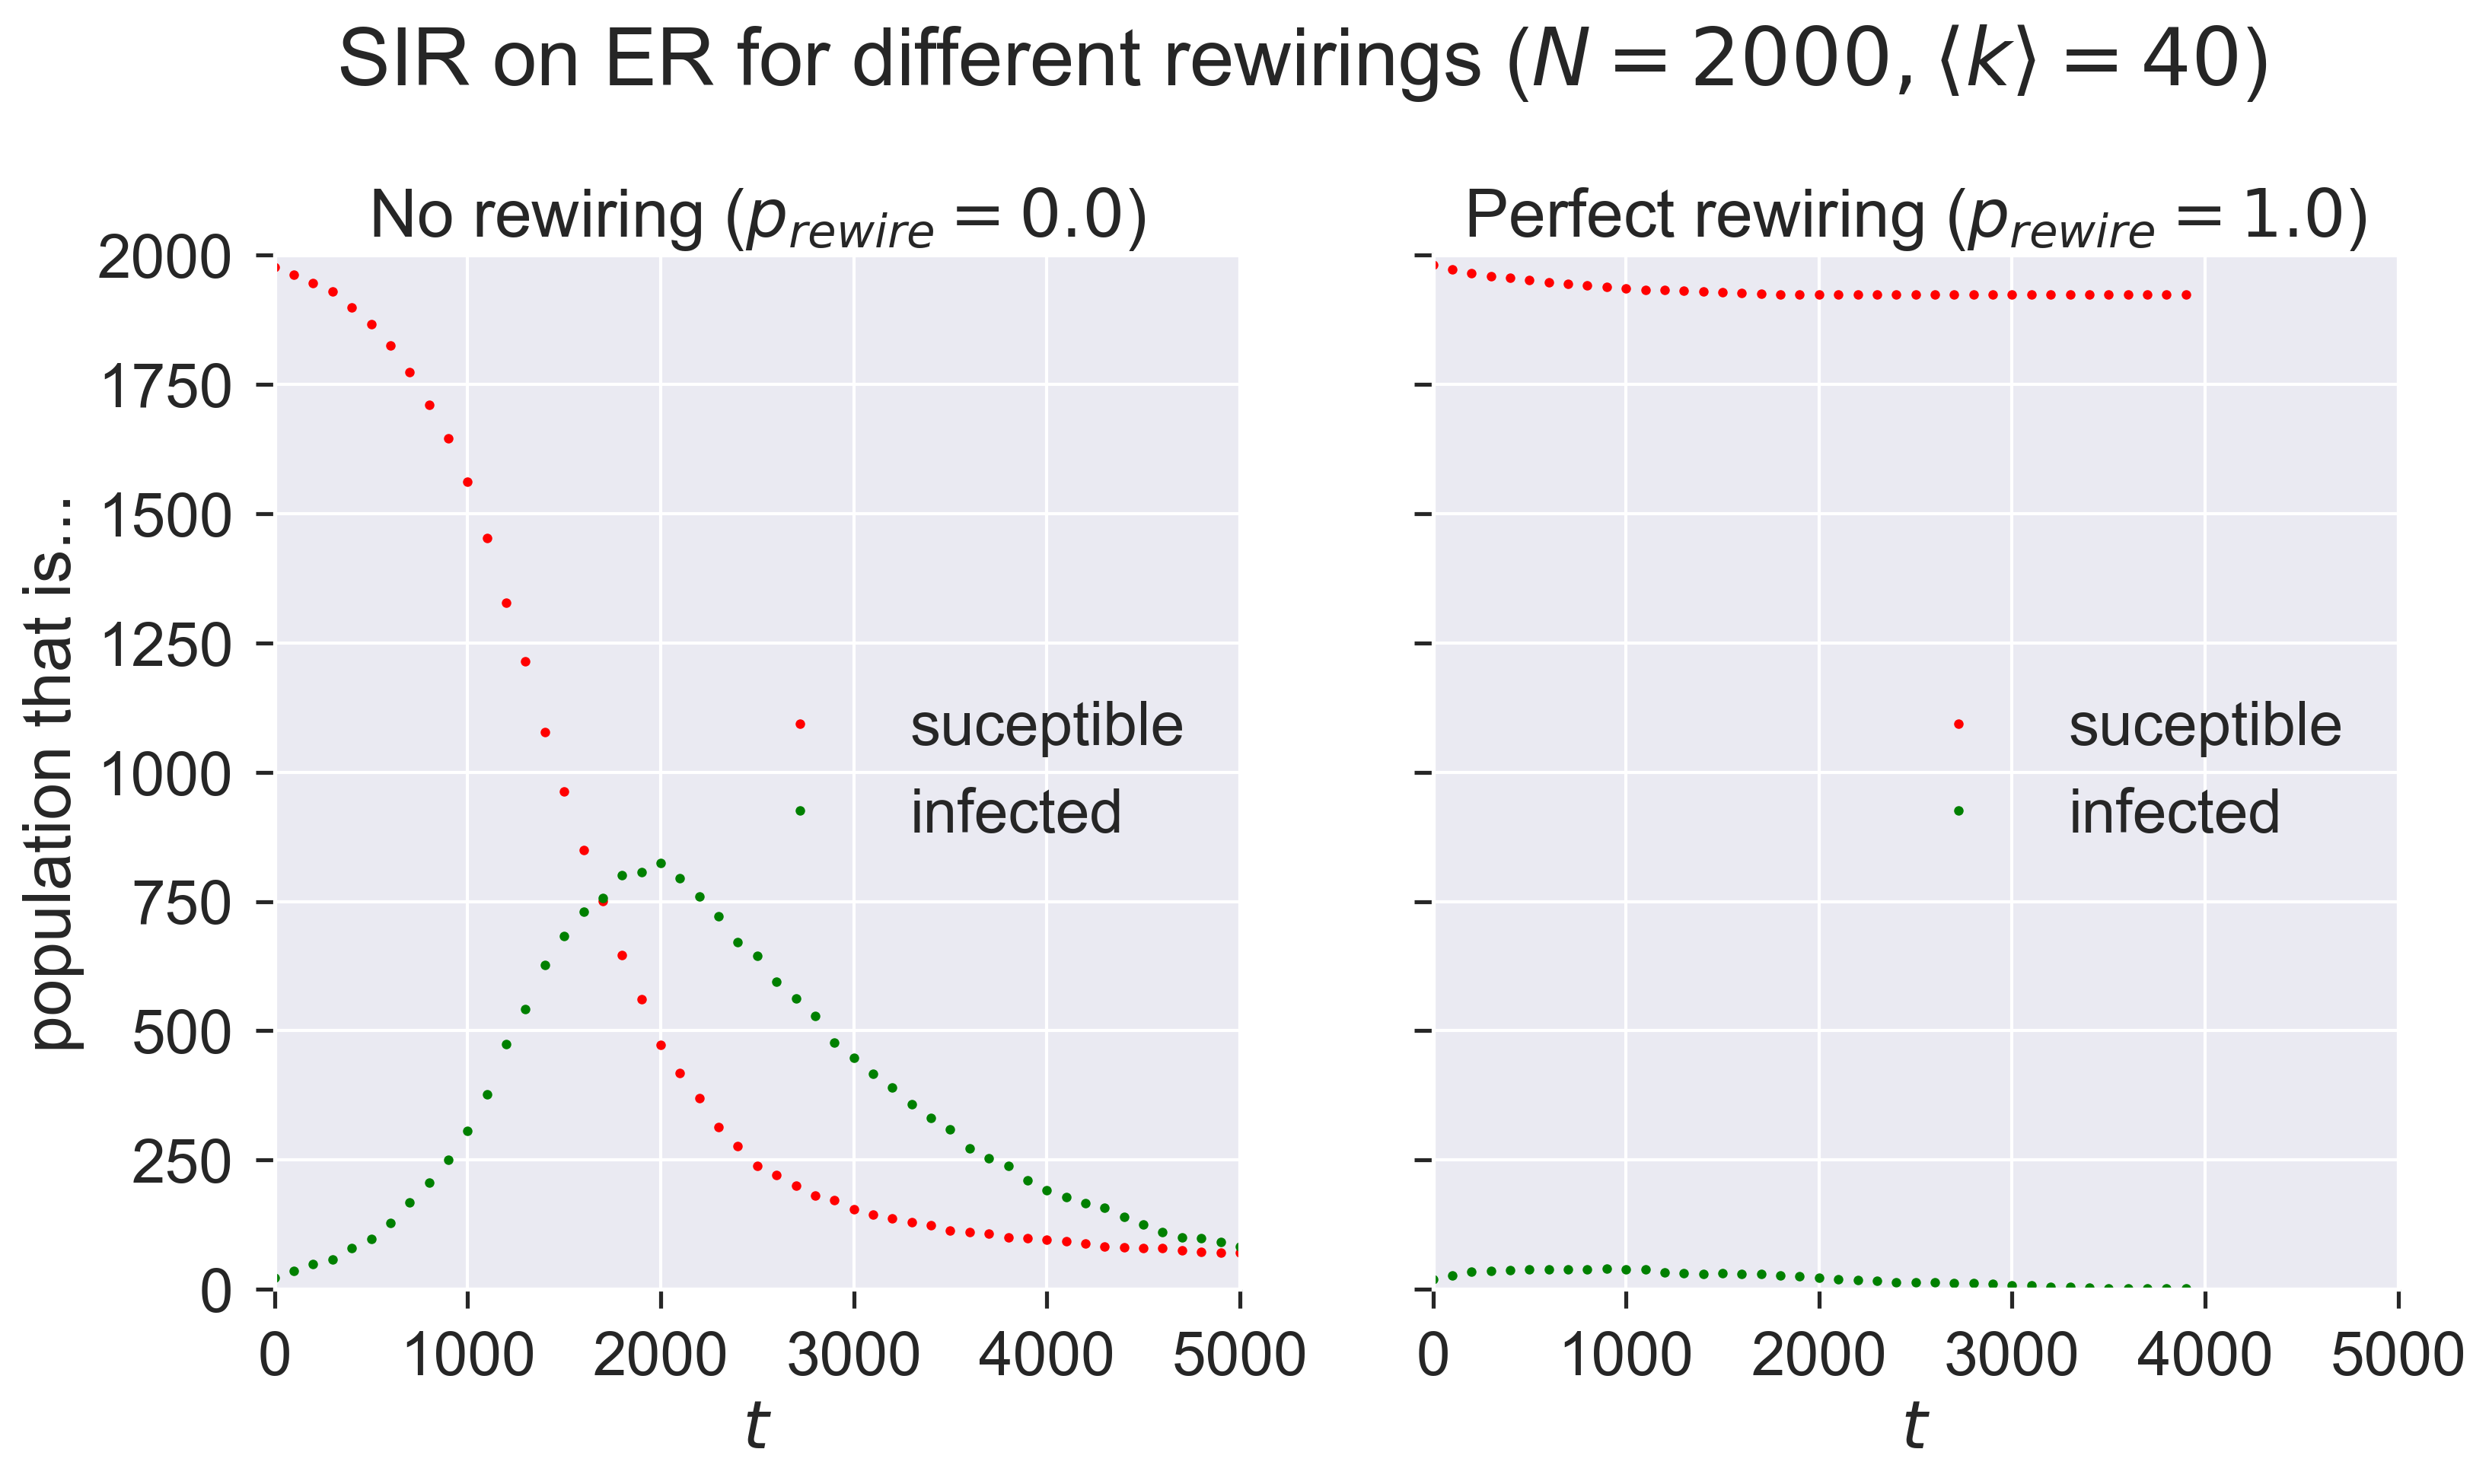

In [14]:
(fig, axs) = plt.subplots(1, 2, sharey=True,
                          figsize=(12, 6))

# plot the two cases side by side
for (ax, rc, caption) in [ (axs[0], rc_0, 'No rewiring ($p_{rewire} = 0.0$)'),
                           (axs[1], rc_1, 'Perfect rewiring ($p_{rewire} = 1.0$)') ]:
    results = rc[epyc.Experiment.RESULTS]
    timeseries = results[epydemic.Monitor.TIMESERIES]
    ts = timeseries[epydemic.Monitor.OBSERVATIONS]
    sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
    iss = timeseries[epydemic.SIR.INFECTED]
    rss = timeseries[epydemic.SIR.REMOVED]
    ax.plot(ts, sss, 'r.', label='suceptible')
    ax.plot(ts, iss, 'g.', label='infected')
    #ax.plot(ts, rss, 'ks', label='removed')
    ax.set_xlim([0, T])    
    ax.set_xlabel('$t$')
    ax.set_ylim([0, N])
    ax.legend(loc='center right')
    ax.set_title(caption)
    
# fine-tune figure
axs[0].set_ylabel('population that is...')
fig.suptitle('SIR on ER for different rewirings ($N = {n}, \\langle k \\rangle = {k}$)'.format(n=N, k=kmean), y=1.05)

_ = plt.show()

Compare the left-hand plot with those we created {ref}`earlier <sec:er-spreading>`. The right-hand plot clearly shows very minimal infection.

Having acquired some confidence in the correctness of the code, we can explore the effect of different values of $p_{rewire}$ on the size of epidemic. We'll do this by performing experiments across the parameter range, with 100 repetitions of each to see what the variance is like. 

In [134]:
lab = epyc.ClusterLab(profile='hogun', notebook=epyc.JSONLabNotebook('datasets/sir-quarantine.json', create=True))

In [140]:
lab[ERNetworkDynamics.N] = N
lab[ERNetworkDynamics.KMEAN] = kmean
lab[epydemic.SIR.P_INFECTED] = pInfected
lab[epydemic.SIR.P_INFECT] = pInfect
lab[epydemic.SIR.P_REMOVE] = pRemove
lab[epydemic.Monitor.DELTA] = T / 50

# adaptation
lab[AdaptiveSIR.P_REWIRE] = numpy.linspace(0.0, 1.0,
                                           num=100)

In [142]:
rc = lab.runExperiment(epyc.RepeatedExperiment(
                         epyc.RepeatedExperiment(e, 10),
                       10))

In [145]:
lab.readyFraction()

1.0

Again this requires quite a lot of computation, but then we can plot the results.

In [15]:
df = epyc.JSONLabNotebook('datasets/sir-quarantine.json').dataframe()

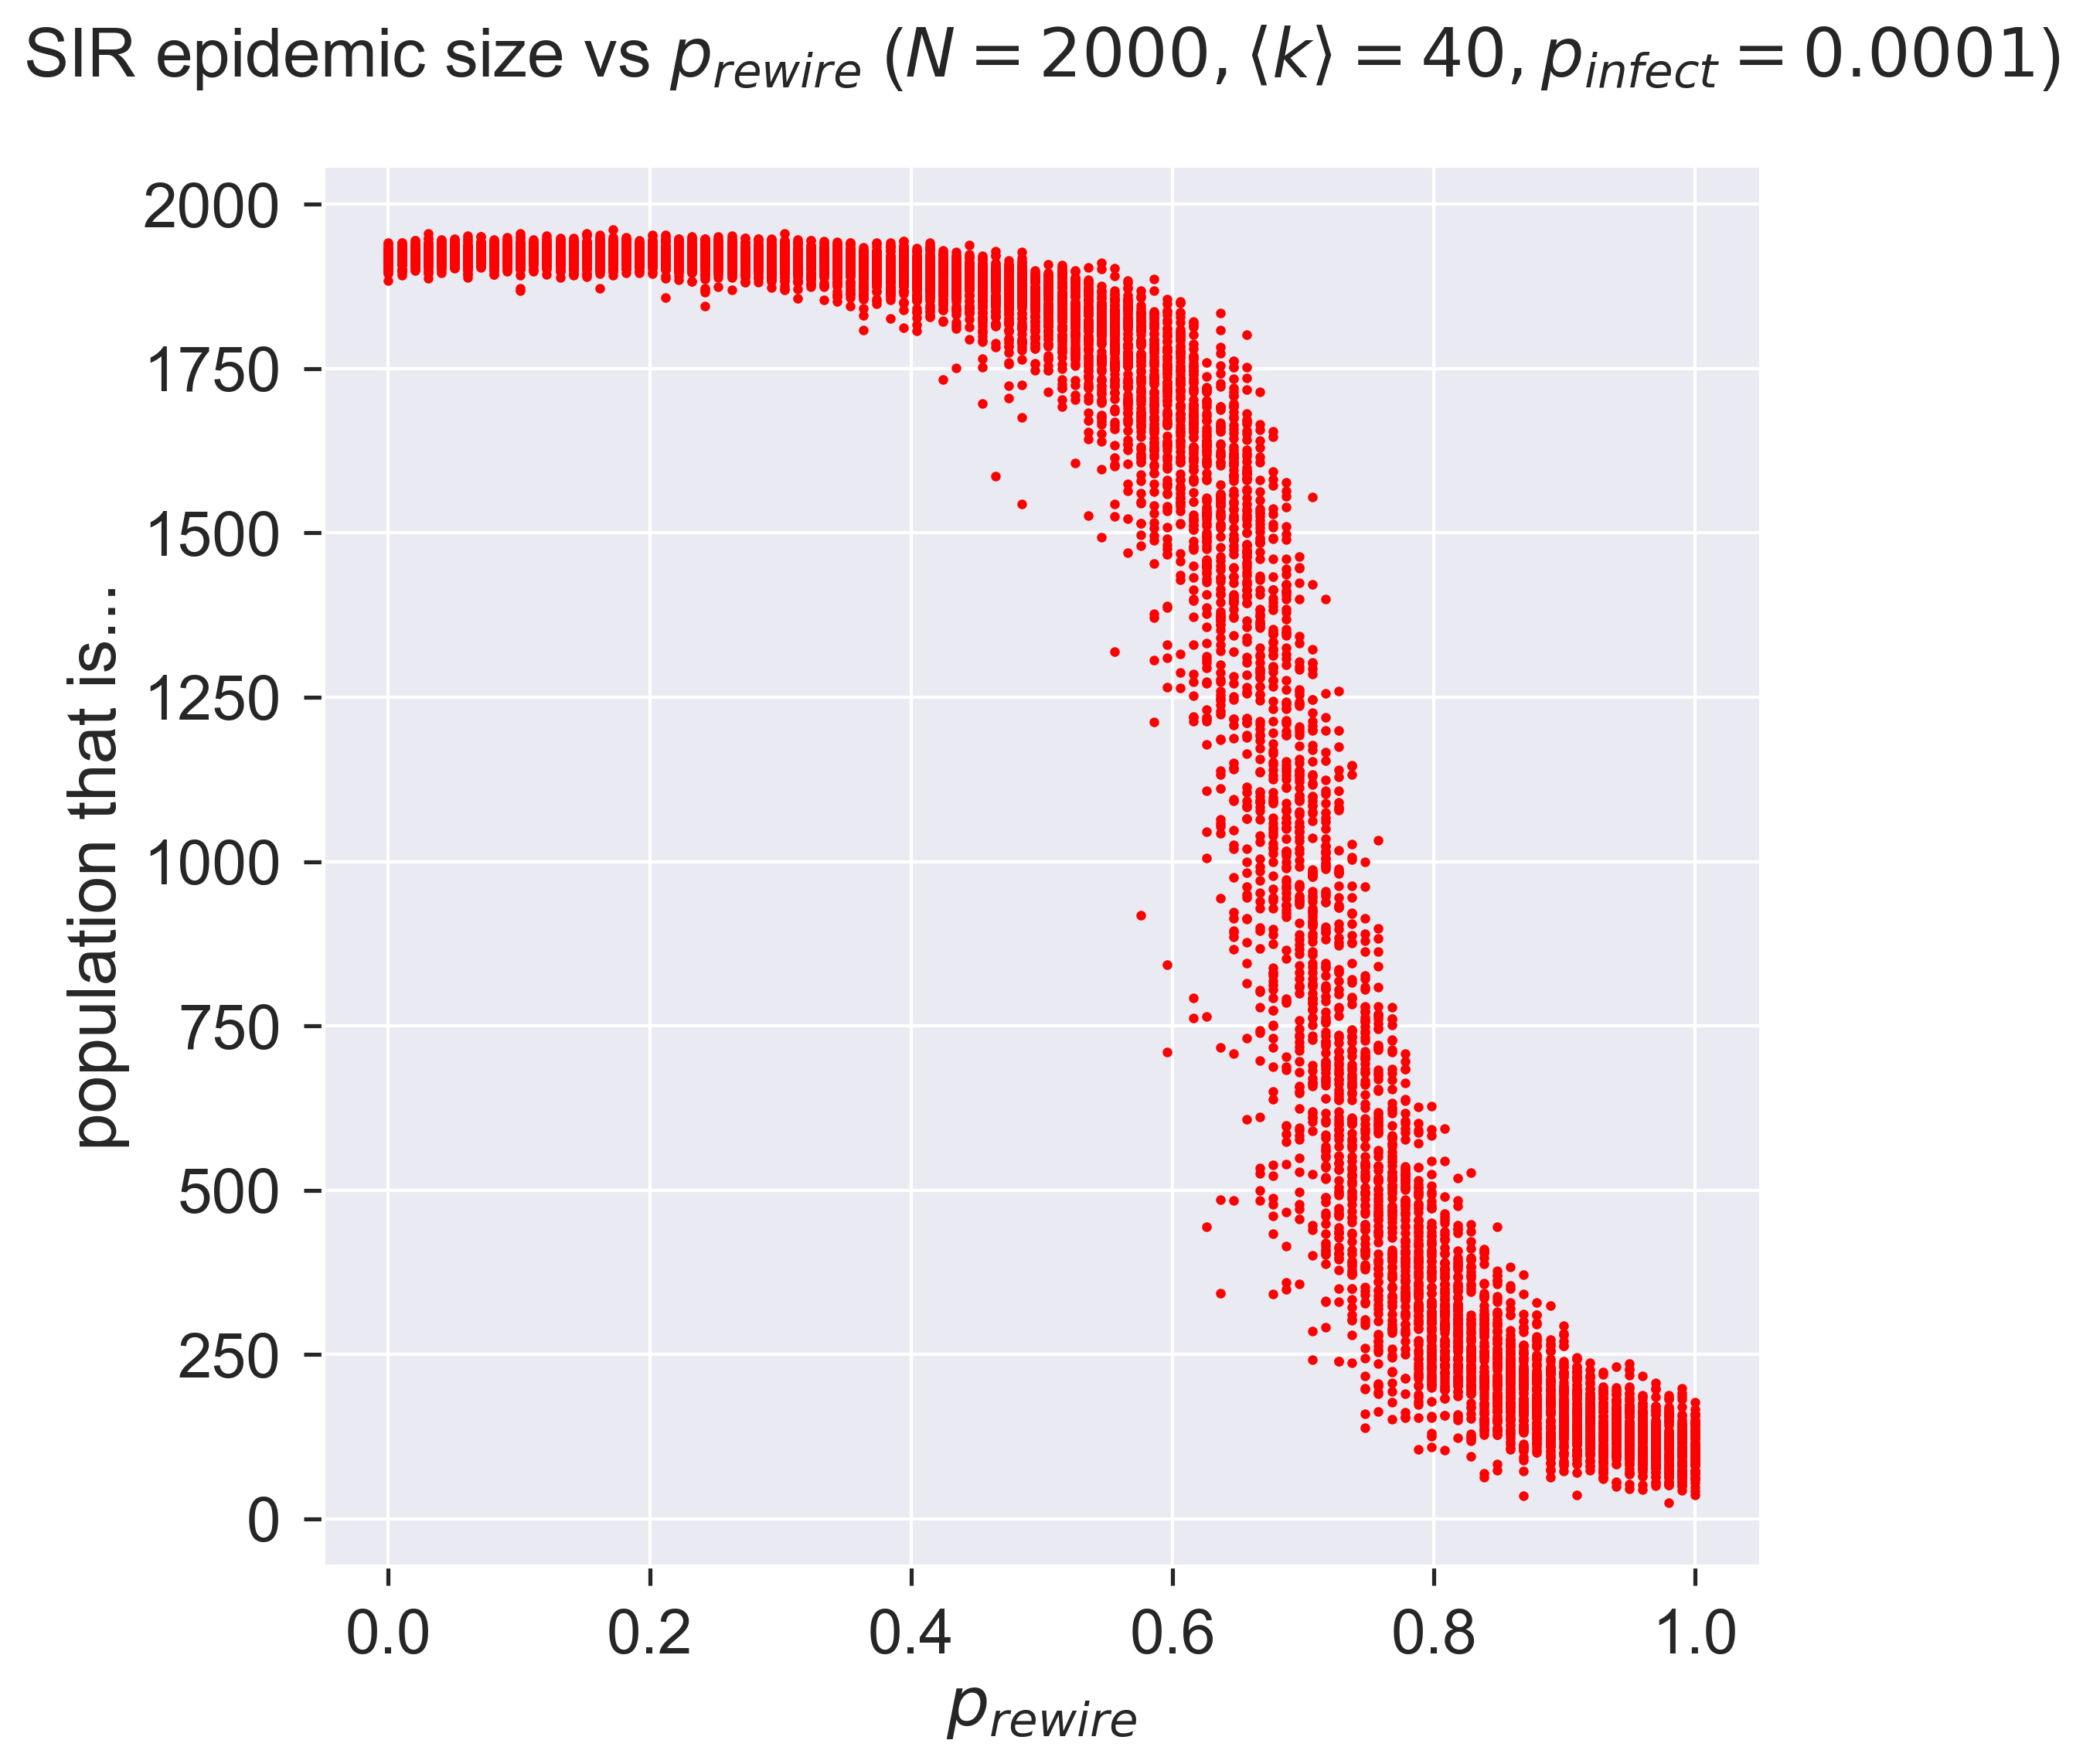

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
ax.plot(df[AdaptiveSIR.P_REWIRE],
        df[epydemic.SIR.REMOVED], 'r.')
ax.set_xlabel('$p_{rewire}$')
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic size vs $p_{rewire}}$ ' + '($N = {n}, \\langle k \\rangle = {k}, '.format(n=N, k=kmean) + 'p_{\\mathit{infect}} = ' + '{p}$)'.format(p=pInfect), y=1.05)

plt.savefig('sir-er-rewiring.png', dpi=300)
_ = plt.show()

That perhaps isn't what we might have expected! At low rates of rewiring the epidemic still infects a lot of the network. But around $p_{rewire} = 0.5$ there's an abrupt change, and the size of the epidemic collapses to near zero, albeit with a lot of variance between different experiments. This suggests that there's a critical region within which rewiring (quarantine, remember) interact with detailed features of the network, so the effect is more or less dramatic depending on the exact details of how the rewiring happens. 

(sec:seir-adaptive-seir)=
## Quarantining people before they're symptomatic

That's about all we can say about quarantine in SIR &ndash; but in SEIR we have more options. Specifically we can explore the **{index}`test, trace, and isolate`** strategy by looking to quarantine people who are exposed but currently asymptomatic: in other words, when we encounter a symptomatic (infected) person, we trace their contacts, test them, and isolate any that we find to be infected.

This is the importance of {index}`SEIR` as a model. It lets us explore additional {index}`countermeasures`, specifically those that rely  on detecting asymptomatic individuals.

Of course no such programme will be 100% effective, so alongside our probability $p_{rewire}$ of rewiring susceptible neighbours away from infected (and now also exposed) nodes, we'll have a probability $p_{detect}$ determining the probability that an exposed neighbour of an infected individual will be detected by the test and trace process. To be clear: $p_{rewire}$ says how effective quarantine is, while $p_{detect}$ says how effective testing is.

(You'll notice we just introduced two new {index}`degrees of freedom` into our SEIR model: that's six parameters now, a lot to be working with.)

Again, we can add our scheme to the standard SEIR model. We'll use the same quarantine function since that process hasn't changed, but we now perform it when an exposed node develops symptoms, and quarantine some fraction of its neighbouring exposed nodes.

In [17]:
%%pxlocal

class AdaptiveSEIR(MonitoredSEIR):
    
    P_DETECT = 'pDetect'   #: Parameter for the probability 
                           # of detecting an exposed
                           # neighbour of an infected node.
    P_REWIRE = 'pRewire'   #: Parameter for the probability
                           # of rewiring an SE or SI edge.
    
    def __init__(self):
        super(AdaptiveSEIR, self).__init__()
        
    def build(self, params):
        super(AdaptiveSEIR, self).build(params)
        
        # store the parameters for later
        self._pDetect = params[self.P_DETECT]
        self._pRewire = params[self.P_REWIRE]

    def quarantine(self, n):
        g = self.network()
        rng = numpy.random.default_rng()
        ms = list(g.neighbors(n))
        for m in ms:
            if self.getCompartment(m) == self.SUSCEPTIBLE and rng.random() <= self._pRewire:
                # a susceptible neighbour, remove link to us
                self.removeEdge(n, m)
                
                # rewire to another random susceptible
                mprime = self.locus(self.SUSCEPTIBLE).draw()
                self.addEdge(m, mprime)
        
    def symptoms(self, t, n):
        # perform a normal becoming-symptomatic event
        super(AdaptiveSEIR, self).symptoms(t, n)
        
        g = self.network()
        rng = numpy.random.default_rng()

        # examine all neighbours and look for exposed
        # nodes to quarantine
        ms = list(g.neighbors(n))
        for m in ms:
            if self.getCompartment(m) == self.EXPOSED and rng.random() <= self._pDetect:
                # detected an exposed individual,
                # quarantine them
                self.quarantine(m)
                
        # quarantine the newly symptomatic node
        self.quarantine(n)

Notice that we've got two places where we look at the {index}`neighbours` of a node and decided what to do with them. In ``symptoms()`` we look for exposed neighbours, detect them with probability $p_{detect}$, and quarantine them if we do; in ``quarantine()`` we look for susceptible neighbours and rewire them with probability $p_{rewire}$. If we set $p_{detect} = 1$, our test-and-trace regime is perfect; if we set $p_{rewire} = 1$, then our isolation regime is perfect.

Again, let's unit-test the code by looking at two extreme cases, where $p_{detect} = 0$ and $p_{detect} = 1$, keeping the value of $p_{rewire}$ the same.   

In [18]:
# network parameters
N = 10000
kmean = 40

# SEIR disease parameters
pExposed = 0.001
pSymptoms = 0.002
pRemove = 0.002
pInfect = 0.000075

# adaptation
pRewire = 0.5

In [19]:
# experimental parameters common to both experiments
params = dict()
params[ERNetworkDynamics.N] = N
params[ERNetworkDynamics.KMEAN] = kmean
params[epydemic.SEIR.P_EXPOSED] = pExposed
params[epydemic.SEIR.P_SYMPTOMS] = pSymptoms
params[epydemic.SEIR.P_REMOVE] = pRemove
params[epydemic.SEIR.P_INFECT_SYMPTOMATIC] = pInfect
params[epydemic.SEIR.P_INFECT_ASYMPTOMATIC] = pInfect
params[epydemic.Monitor.DELTA] = T / 50
params[AdaptiveSEIR.P_REWIRE] = pRewire

# create model and experiment over ER network
m = AdaptiveSEIR()
m.setMaximumTime(T)
e = ERNetworkDynamics(m)

# no detection
params[AdaptiveSEIR.P_DETECT] = 0.0
rc_0 = e.set(params).run()

# perfect detection
params[AdaptiveSEIR.P_DETECT] = 1.0
rc_1 = e.set(params).run()

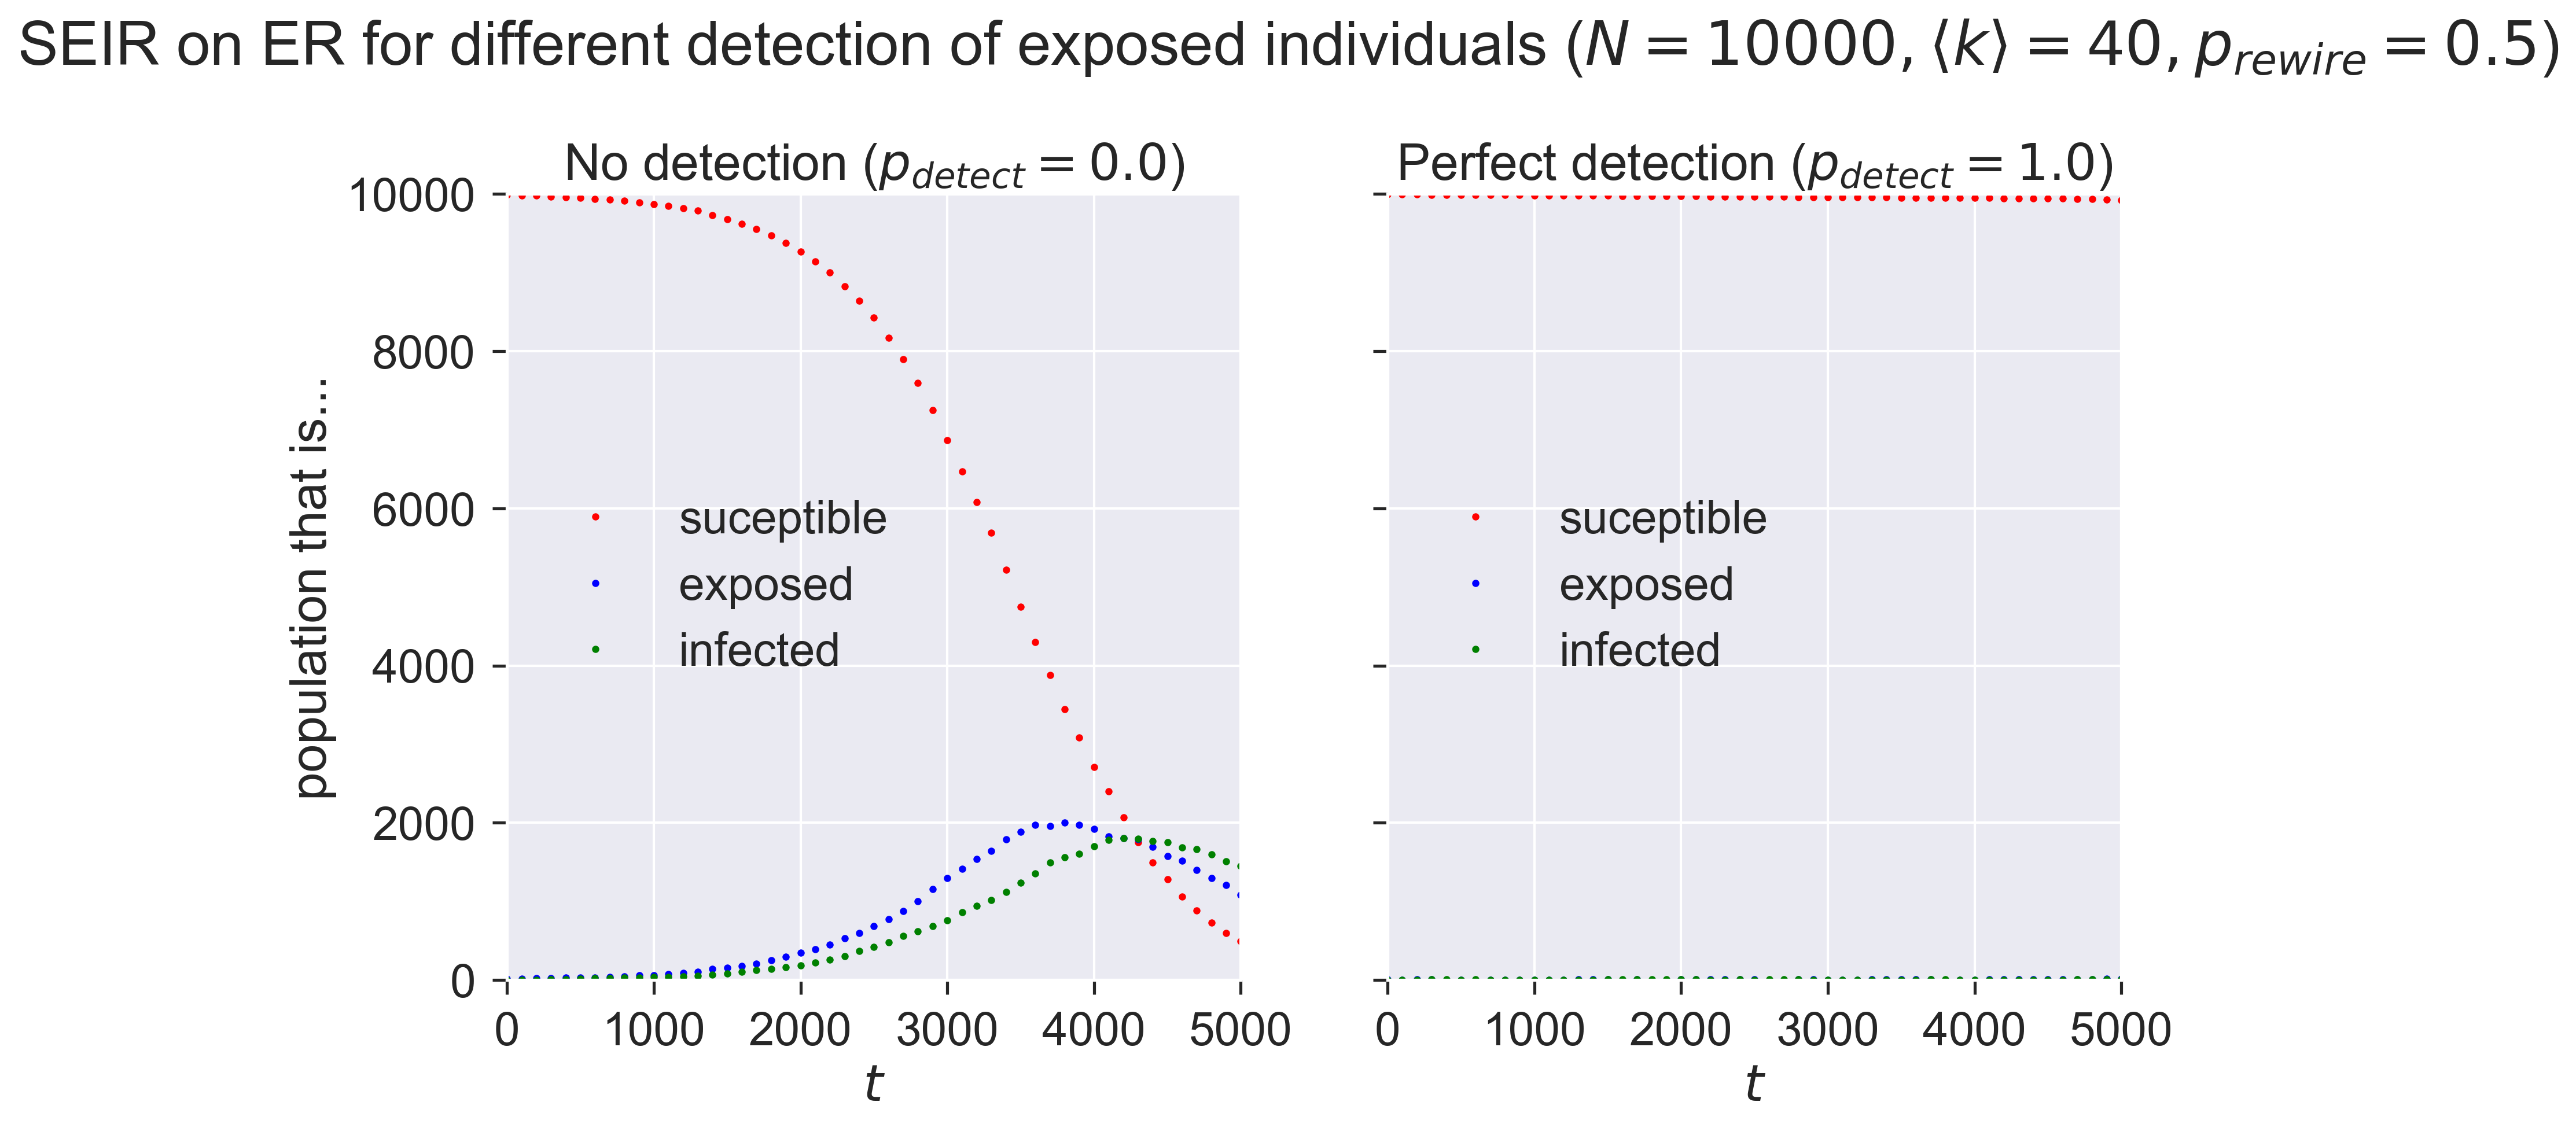

In [20]:
(fig, axs) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# plot the two cases side by side
for (ax, rc, caption) in [ (axs[0], rc_0, 'No detection ($p_{detect} = 0.0$)'),
                           (axs[1], rc_1, 'Perfect detection ($p_{detect} = 1.0$)') ]:
    results = rc[epyc.Experiment.RESULTS]
    timeseries = results[epydemic.Monitor.TIMESERIES]
    ts = timeseries[epydemic.Monitor.OBSERVATIONS]
    sss = timeseries[epydemic.SEIR.SUSCEPTIBLE]
    ess = timeseries[epydemic.SEIR.EXPOSED]
    iss = timeseries[epydemic.SEIR.INFECTED]
    rss = timeseries[epydemic.SEIR.REMOVED]
    ax.plot(ts, sss, 'r.', label='suceptible')
    ax.plot(ts, ess, 'b.', label='exposed')
    ax.plot(ts, iss, 'g.', label='infected')
    #ax.plot(ts, rss, 'ks', label='removed')
    ax.set_xlim([0, T])    
    ax.set_xlabel('$t$')
    ax.set_ylim([0, N])
    ax.legend(loc='center left')
    ax.set_title(caption)
    
# fine-tune figure
axs[0].set_ylabel('population that is...')
fig.suptitle('SEIR on ER for different detection of exposed individuals ($N = {n}, \\langle k \\rangle = {k}'.format(n=N, k=kmean) + ', p_{rewire} = ' + '{p}$)'.format(p=pRewire), y=1.05)

_ = plt.show()

With no detection (in the left-hand plot) of exposed nodes we see an epidemic break out, albeit quite a small one. The exposed nodes start spreading infection silently, but since they're never detected the only countermeasures that happen are a 50%-effective quarantine of infected nodes. In the right-hand plot the perfect detection means that the countermeasures are very effective, even when the quarantine is only 50% effective.

Let's see what effect detection efficiency has. Remember, $p_{detect}$ is the probability that an exposed neighbour of an infected individual will be detected and then quarantined: you can think of it as a measure of how effectively we're doing the "test" and "trace" parts of "test, trace, and isolate". We probably expect that a more effective detection regime &ndash; where more exposed individuals are detected earlier &ndash; will have the effect of reducing the size of the epidemic.  

In [229]:
lab = epyc.ClusterLab(profile='hogun', notebook=epyc.JSONLabNotebook('datasets/seir-quarantine.json', create=True))

We need to pick values for the other parameters in the model, so let's rather arbitrarily say that asymptomatic and symptomatic infection happen with the same probability, and that we have a quarantine regime that's 50%-effective both for infected people and for those we uncover through testing.

In [237]:
lab[ERNetworkDynamics.N] = N
lab[ERNetworkDynamics.KMEAN] = kmean

lab[epydemic.SEIR.P_EXPOSED] = 0.001
lab[epydemic.SEIR.P_REMOVE] = 0.002
lab[epydemic.SEIR.P_INFECT_ASYMPTOMATIC] = 0.000075
lab[epydemic.SEIR.P_INFECT_SYMPTOMATIC] = 0.000075
lab[epydemic.SEIR.P_SYMPTOMS] = 0.002
lab[epydemic.Monitor.DELTA] = T / 50

# adaptation
pRewire = 0.5
lab[AdaptiveSEIR.P_REWIRE] = pRewire
lab[AdaptiveSEIR.P_DETECT] = numpy.linspace(0.0, 1.0,
                                            num=100)

In [238]:
m = AdaptiveSEIR()
e = ERNetworkDynamics(m)
rc = lab.runExperiment(epyc.RepeatedExperiment(
                         epyc.RepeatedExperiment(e, 10), 
                       10))

In [241]:
lab.readyFraction()

1.0

More simulation results in the following.

In [21]:
df = epyc.JSONLabNotebook('datasets/seir-quarantine.json').dataframe()

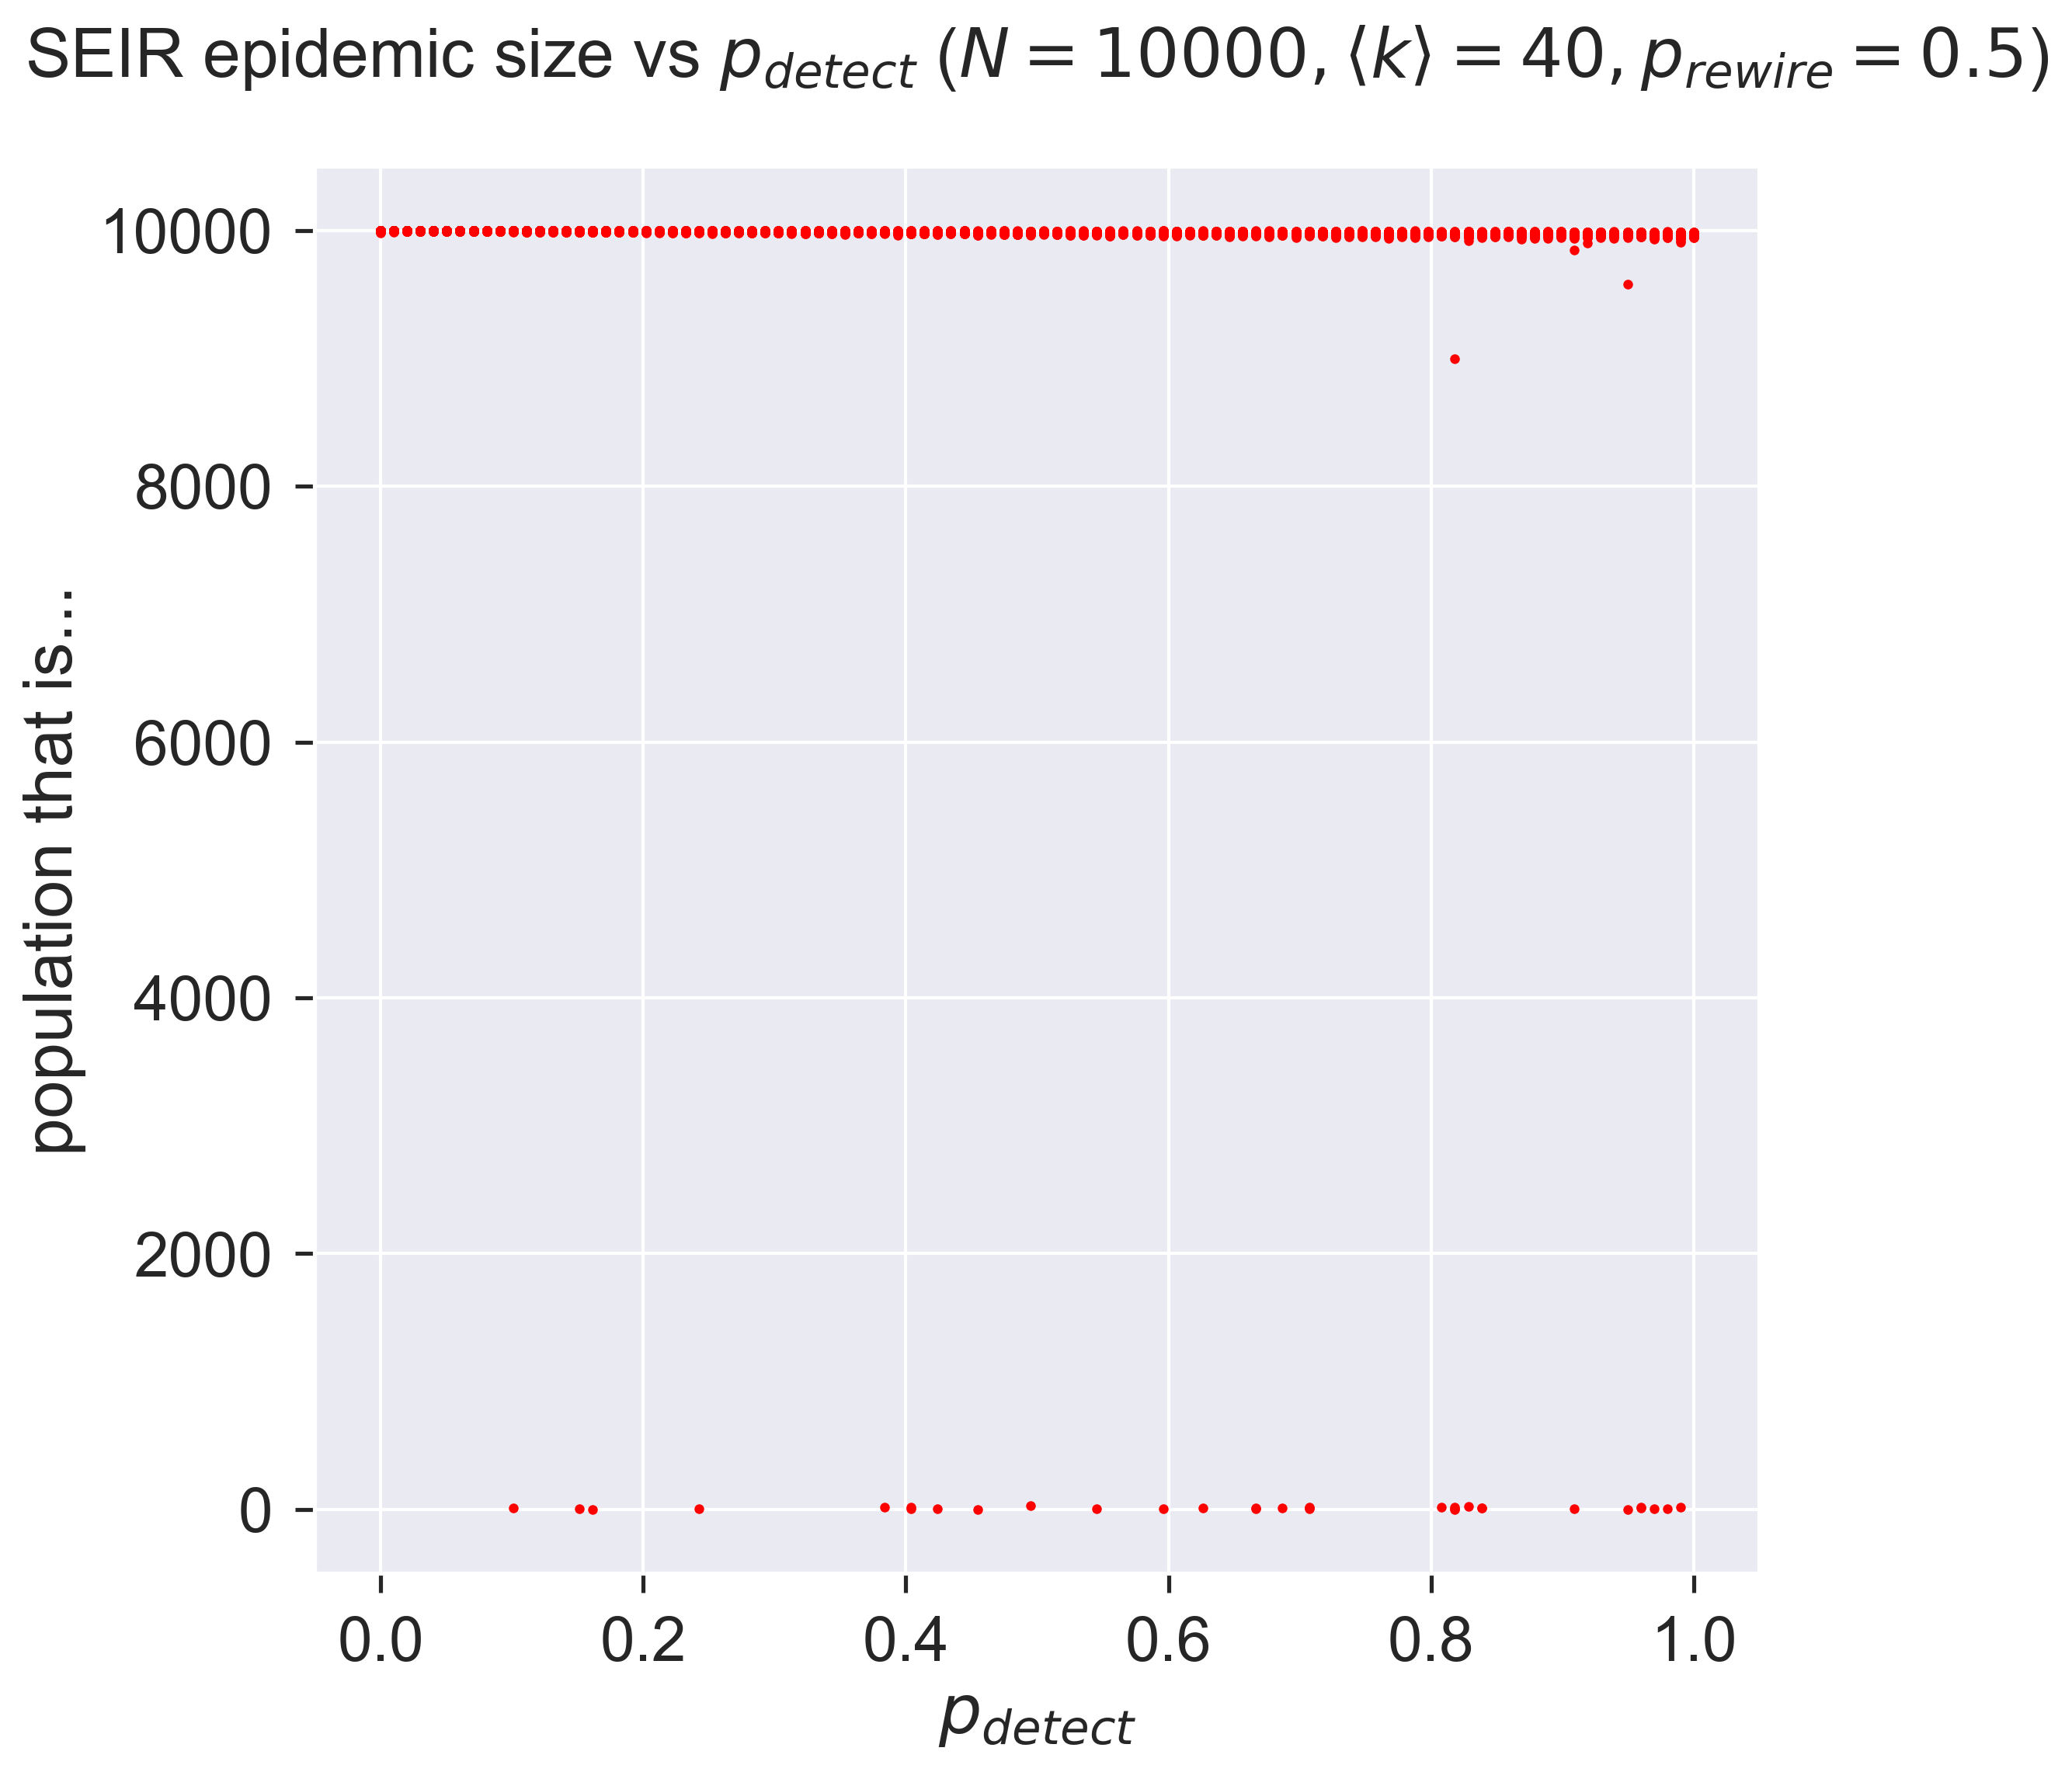

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
results = df[df[AdaptiveSEIR.P_REWIRE] == pRewire]
ax.plot(results[AdaptiveSEIR.P_DETECT],
        results[epydemic.SEIR.REMOVED], 'r.')
ax.set_xlabel('$p_{detect}$')
ax.set_ylabel('population that is...')
ax.set_title('SEIR epidemic size vs $p_{detect}}$ ' + '($N = {n}, \\langle k \\rangle = {k}, '.format(n=N, k=kmean) + 'p_{rewire} = ' + '{p}$)'.format(p=pRewire), y=1.05)

_ = plt.show()

Perhaps a little disappointing: it seems that detection doesn't have much effect in this case. You'll notice that it's not *no* effect: there are cases right across the graph in which the size of the outbreak is around zero, but in the majority of cases there is a large epidemic.

Might this be to do with the effectiveness of quarantine? If we adopt an 80%-effective regime, what then happens?

In [8]:
pRewire = 0.8

In [ ]:
lab[AdaptiveSEIR.P_REWIRE] = pRewire
rc = lab.runExperiment(epyc.RepeatedExperiment(
                         epyc.RepeatedExperiment(e, 10),
                       10))

In [246]:
lab.readyFraction()

1.0

In [9]:
df = epyc.JSONLabNotebook('datasets/seir-quarantine.json').dataframe()

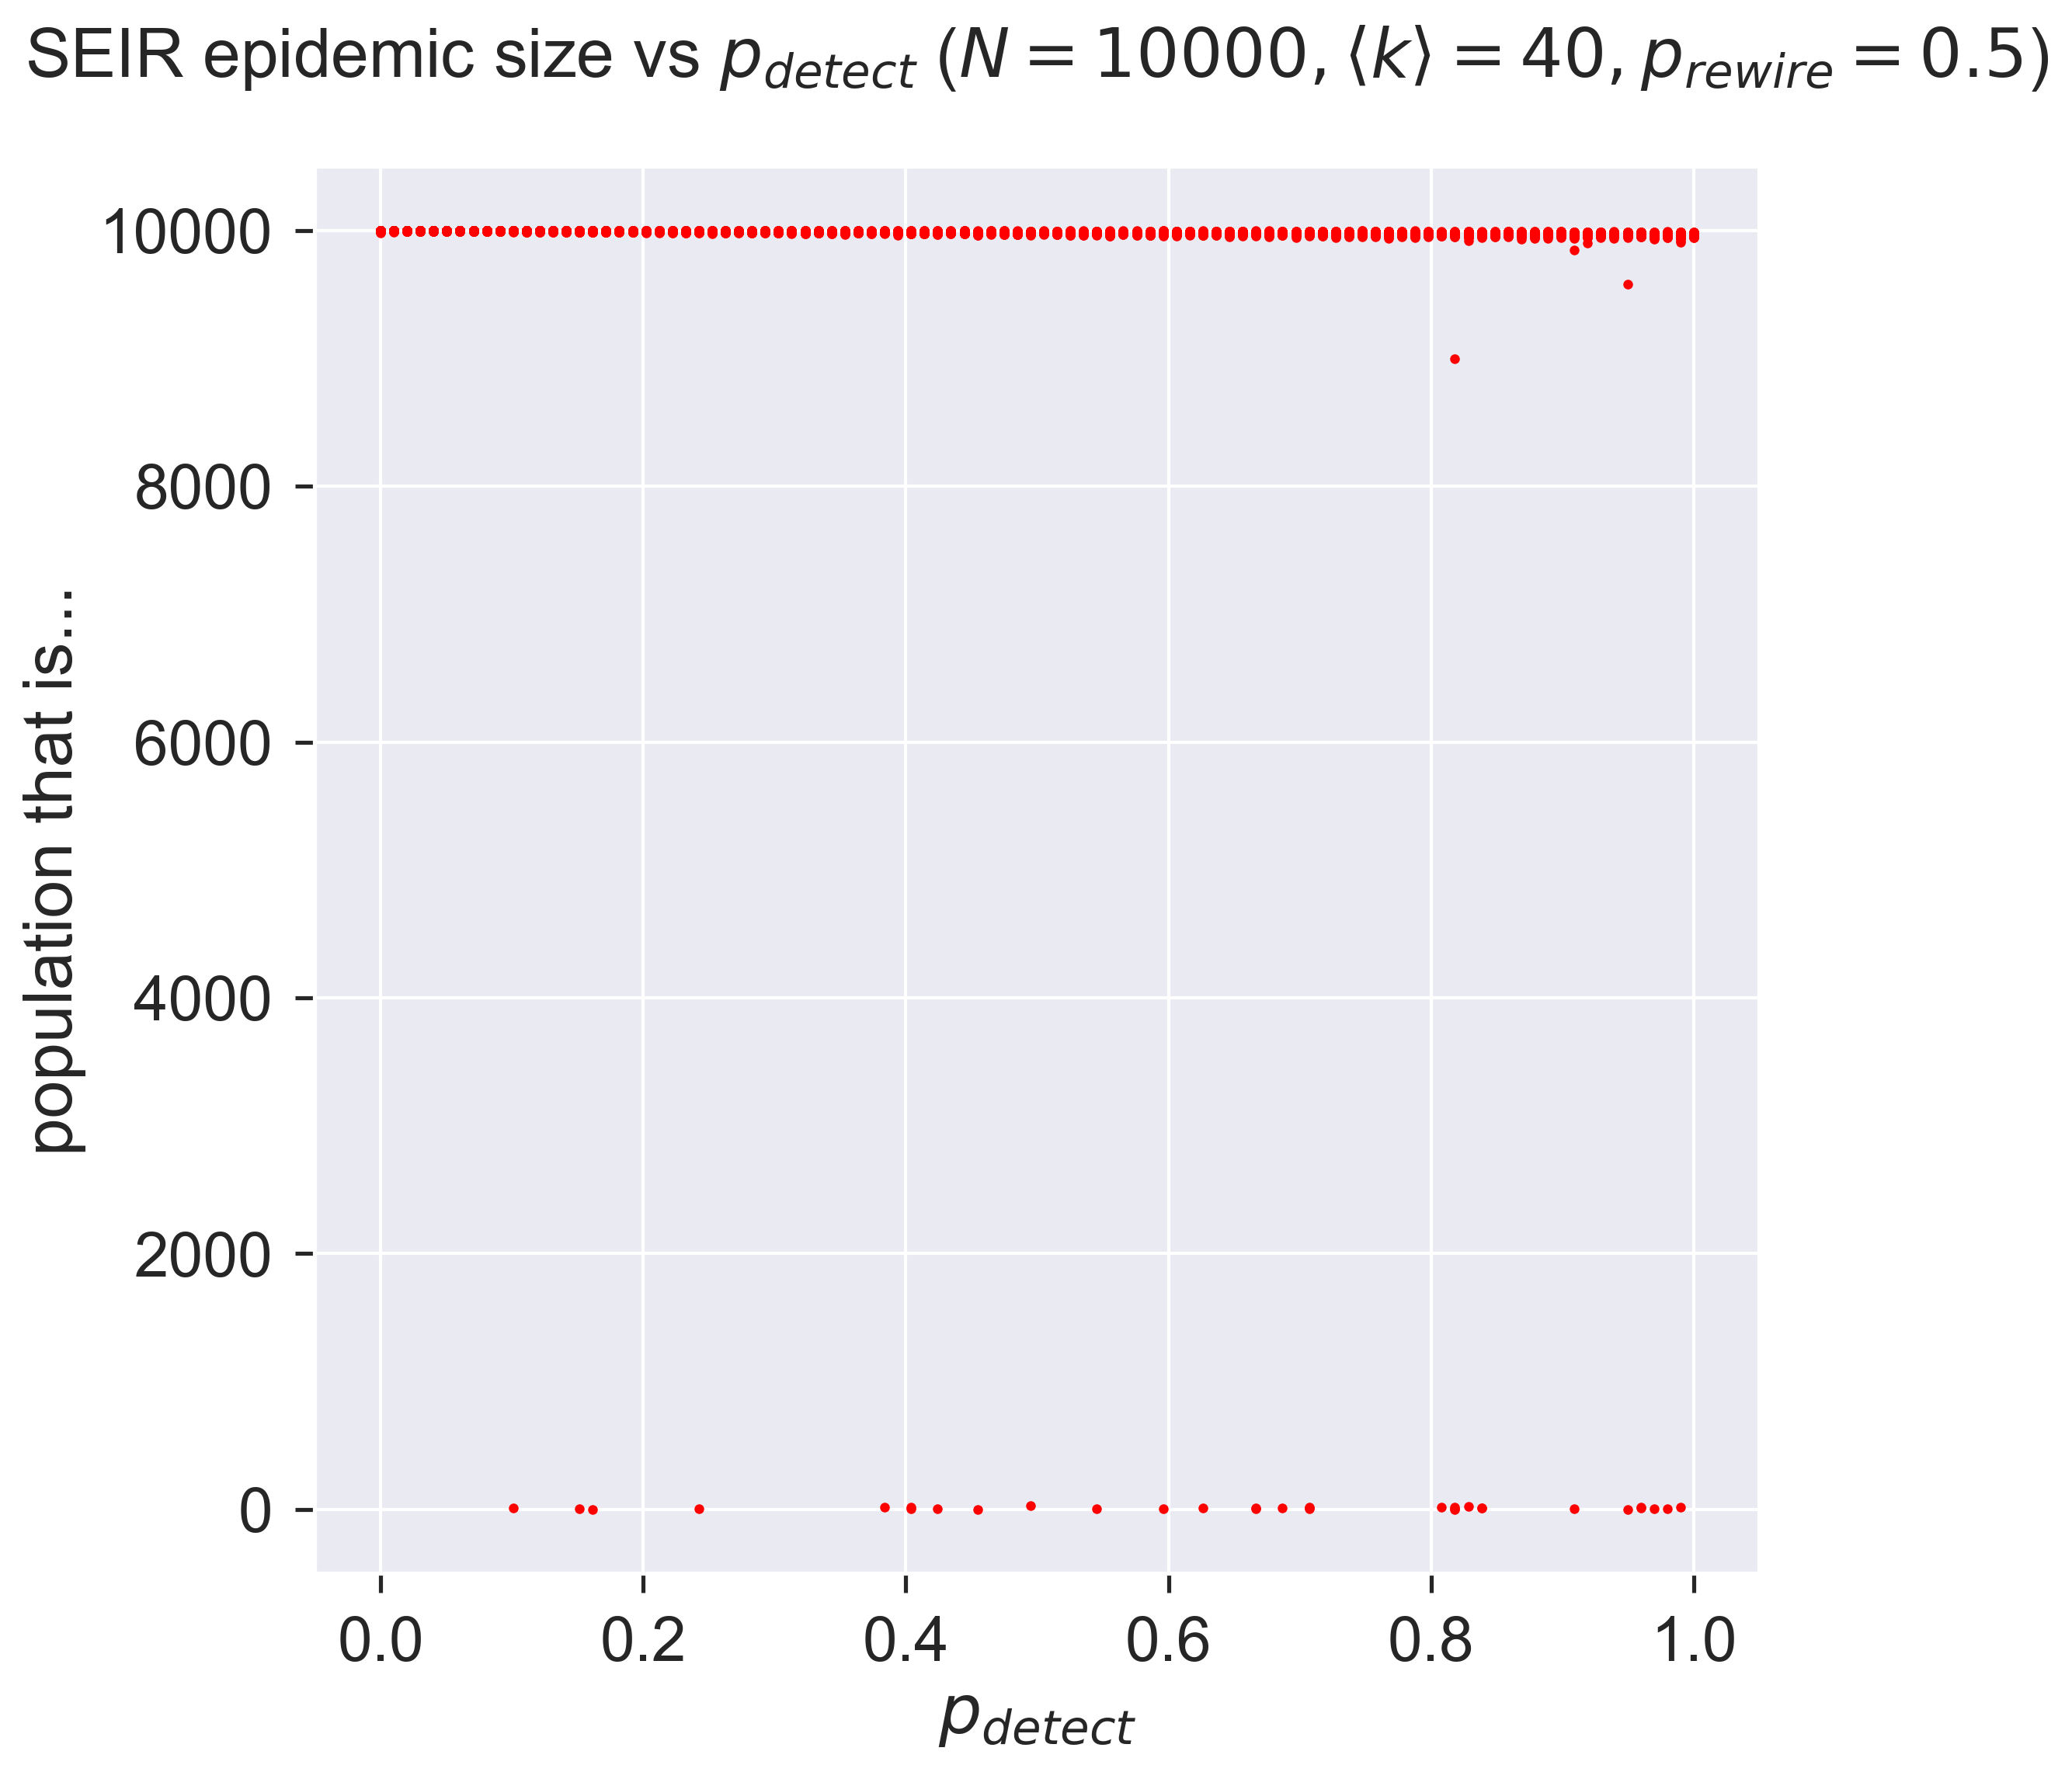

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
results = df[df[AdaptiveSEIR.P_REWIRE] == pRewire]
ax.plot(results[AdaptiveSEIR.P_DETECT],
        results[epydemic.SEIR.REMOVED], 'r.')
ax.set_xlabel('$p_{detect}$')
ax.set_ylabel('population that is...')
ax.set_title('SEIR epidemic size vs $p_{detect}}$ ' + '($N = {n}, \\langle k \\rangle = {k}, '.format(n=N, k=kmean) + 'p_{rewire} = ' + '{p}$)'.format(p=pRewire), y=1.05)

plt.savefig('seir-er-rewiring.png', dpi=300)
_ = plt.show()

*Very* different! What are we seeing?

Firstly, notice that in almost all cases we have some examples of epidemics with very small outbreaks, suggesting that even low detection rates *can* make a difference. But at low values of $p_{detect}$ that difference is really rather sparse: it doesn't happen often. 

As $p_{detect}$ increases &ndash; that is, as testing and tracing becomes more effective, we start to see a strange effect: a "waterfall" of results. Remember that each point on the graph represents a single experimental epidemic.  Within the waterfall, some of these experiments have huge outbreaks, some have none, and some fall in between. This may suggest that the really detailed structure of the network makes a difference: some small thing is enough to change the way the stochastic process evolves and so swing the results.

Then as we continue to increase $p_{detect}$ we see something else. The "waterfall" continues, but suddenly there are no really large outbreaks. Detection and quarantine aren't stopping epidemics from happening, but they *are* limiting their size. Finally we see very effective control when we have perfect detection &ndash; although still *imperfect* control, because of the imperfect quarantine.

## Questions for discussion

- What sort of detection activities might you impose in an epidemic? How effective would it be? What could you do to make it *more* effective?
- What would happen if you had vaccination *and* test, trace, and isolate in place at the same time? Would one compensate for weaknesses in the other?